In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
dataset = pd.read_csv('../../../../../../data/zeda/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [22]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [23]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [24]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [25]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [26]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [27]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [29]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [30]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [32]:
# define model
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same", input_shape=(train_X.shape[1], train_X.shape[2])))
# model_cnn.add(layers.Conv2D(filters=64, 
#                                     kernel_size=3, 
#                                     activation='relu', 
#                                     padding="same",
#                                     input_shape=(train_X.shape[1], train_X.shape[2], 1)))
# model_cnn.add(layers.MaxPooling2D(pool_size=2))
model_cnn.add(layers.Flatten())
# model_cnn.add(layers.Dense(8, activation='relu'))5
model_cnn.add(layers.Dense(train_y.shape[1]))
model_cnn.summary()

2022-09-21 18:26:31.611988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-21 18:26:31.686176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2022-09-21 18:26:31.687074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-21 18:26:31.690562: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-21 18:26:31.693283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-09-21 18:26:31.694559: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuran

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 72, 64)            3648      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 96)                442464    
Total params: 446,112
Trainable params: 446,112
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000


2022-09-21 18:26:35.103518: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-21 18:26:35.330305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-09-21 18:26:36.477238: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2022-09-21 18:26:36.857913: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.18026, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 15s - loss: 0.0711 - mae: 0.2131 - val_loss: 0.0514 - val_mae: 0.1803
Epoch 2/2000

Epoch 00002: val_mae improved from 0.18026 to 0.13713, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0213 - mae: 0.1166 - val_loss: 0.0288 - val_mae: 0.1371
Epoch 3/2000

Epoch 00003: val_mae improved from 0.13713 to 0.11820, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0149 - mae: 0.0975 - val_loss: 0.0217 - val_mae: 0.1182
Epoch 4/2000

Epoch 00004: val_mae improved from 0.11820 to 0.10307, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0114 - mae: 0.0843 - val_loss: 0.0168 - val_mae: 0.1031
Epoch 5/2000

Epoch 00005: val_mae improved from 0.10307 to 0.09118, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0089 - mae: 0.0735 - val_loss: 0.0133 - val_mae: 0.0912
Epoch 6/2000

Epoch 00006: val_

Epoch 43/2000

Epoch 00043: val_mae improved from 0.04494 to 0.04455, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0018 - mae: 0.0317 - val_loss: 0.0033 - val_mae: 0.0446
Epoch 44/2000

Epoch 00044: val_mae improved from 0.04455 to 0.04417, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0018 - mae: 0.0314 - val_loss: 0.0032 - val_mae: 0.0442
Epoch 45/2000

Epoch 00045: val_mae improved from 0.04417 to 0.04379, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0031 - val_mae: 0.0438
Epoch 46/2000

Epoch 00046: val_mae improved from 0.04379 to 0.04343, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0017 - mae: 0.0307 - val_loss: 0.0031 - val_mae: 0.0434
Epoch 47/2000

Epoch 00047: val_mae improved from 0.04343 to 0.04307, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 0.0017 - mae: 0.0304 - val_loss: 0.0030 - val_mae: 0.0431
Epoch 48/2

Epoch 85/2000

Epoch 00085: val_mae improved from 0.03432 to 0.03417, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 9.2078e-04 - mae: 0.0223 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 86/2000

Epoch 00086: val_mae improved from 0.03417 to 0.03402, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 9.0993e-04 - mae: 0.0221 - val_loss: 0.0019 - val_mae: 0.0340
Epoch 87/2000

Epoch 00087: val_mae improved from 0.03402 to 0.03387, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 8.9934e-04 - mae: 0.0220 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 88/2000

Epoch 00088: val_mae improved from 0.03387 to 0.03373, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 8.8898e-04 - mae: 0.0219 - val_loss: 0.0019 - val_mae: 0.0337
Epoch 89/2000

Epoch 00089: val_mae improved from 0.03373 to 0.03359, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 8.7886e-04 - mae: 0.0217 - val_loss: 0.0018 - val_ma

Epoch 126/2000

Epoch 00126: val_mae improved from 0.02960 to 0.02951, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 6.2091e-04 - mae: 0.0181 - val_loss: 0.0014 - val_mae: 0.0295
Epoch 127/2000

Epoch 00127: val_mae improved from 0.02951 to 0.02942, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 6.1611e-04 - mae: 0.0180 - val_loss: 0.0014 - val_mae: 0.0294
Epoch 128/2000

Epoch 00128: val_mae improved from 0.02942 to 0.02933, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 6.1140e-04 - mae: 0.0180 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 129/2000

Epoch 00129: val_mae improved from 0.02933 to 0.02924, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 6.0676e-04 - mae: 0.0179 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 130/2000

Epoch 00130: val_mae improved from 0.02924 to 0.02916, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 6.0219e-04 - mae: 0.0178 - val_loss: 0.0014 - v

Epoch 167/2000

Epoch 00167: val_mae improved from 0.02647 to 0.02640, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 4.7269e-04 - mae: 0.0157 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 168/2000

Epoch 00168: val_mae improved from 0.02640 to 0.02634, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 4.6999e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 169/2000

Epoch 00169: val_mae improved from 0.02634 to 0.02627, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 4.6732e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 170/2000

Epoch 00170: val_mae improved from 0.02627 to 0.02620, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 4.6467e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 171/2000

Epoch 00171: val_mae improved from 0.02620 to 0.02614, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 4.6206e-04 - mae: 0.0155 - val_loss: 0.0011 - v

Epoch 208/2000

Epoch 00208: val_mae improved from 0.02394 to 0.02388, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.8352e-04 - mae: 0.0140 - val_loss: 9.4478e-04 - val_mae: 0.0239
Epoch 209/2000

Epoch 00209: val_mae improved from 0.02388 to 0.02382, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.8180e-04 - mae: 0.0140 - val_loss: 9.4052e-04 - val_mae: 0.0238
Epoch 210/2000

Epoch 00210: val_mae improved from 0.02382 to 0.02377, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.8011e-04 - mae: 0.0139 - val_loss: 9.3624e-04 - val_mae: 0.0238
Epoch 211/2000

Epoch 00211: val_mae improved from 0.02377 to 0.02371, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.7842e-04 - mae: 0.0139 - val_loss: 9.3203e-04 - val_mae: 0.0237
Epoch 212/2000

Epoch 00212: val_mae improved from 0.02371 to 0.02366, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.7676e-04 - mae: 0.0139 - val_

Epoch 248/2000

Epoch 00248: val_mae improved from 0.02194 to 0.02190, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.2616e-04 - mae: 0.0128 - val_loss: 7.9695e-04 - val_mae: 0.0219
Epoch 249/2000

Epoch 00249: val_mae improved from 0.02190 to 0.02185, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.2497e-04 - mae: 0.0128 - val_loss: 7.9376e-04 - val_mae: 0.0219
Epoch 250/2000

Epoch 00250: val_mae improved from 0.02185 to 0.02181, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.2380e-04 - mae: 0.0127 - val_loss: 7.9063e-04 - val_mae: 0.0218
Epoch 251/2000

Epoch 00251: val_mae improved from 0.02181 to 0.02176, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.2262e-04 - mae: 0.0127 - val_loss: 7.8749e-04 - val_mae: 0.0218
Epoch 252/2000

Epoch 00252: val_mae improved from 0.02176 to 0.02172, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 3.2146e-04 - mae: 0.0127 - val_

Epoch 288/2000

Epoch 00288: val_mae improved from 0.02031 to 0.02027, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.8509e-04 - mae: 0.0119 - val_loss: 6.8548e-04 - val_mae: 0.0203
Epoch 289/2000

Epoch 00289: val_mae improved from 0.02027 to 0.02024, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.8422e-04 - mae: 0.0118 - val_loss: 6.8311e-04 - val_mae: 0.0202
Epoch 290/2000

Epoch 00290: val_mae improved from 0.02024 to 0.02020, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.8334e-04 - mae: 0.0118 - val_loss: 6.8073e-04 - val_mae: 0.0202
Epoch 291/2000

Epoch 00291: val_mae improved from 0.02020 to 0.02017, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.8248e-04 - mae: 0.0118 - val_loss: 6.7842e-04 - val_mae: 0.0202
Epoch 292/2000

Epoch 00292: val_mae improved from 0.02017 to 0.02013, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.8162e-04 - mae: 0.0118 - val_

Epoch 328/2000

Epoch 00328: val_mae improved from 0.01901 to 0.01898, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.5431e-04 - mae: 0.0111 - val_loss: 6.0307e-04 - val_mae: 0.0190
Epoch 329/2000

Epoch 00329: val_mae improved from 0.01898 to 0.01895, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.5364e-04 - mae: 0.0111 - val_loss: 6.0136e-04 - val_mae: 0.0190
Epoch 330/2000

Epoch 00330: val_mae improved from 0.01895 to 0.01892, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.5297e-04 - mae: 0.0111 - val_loss: 5.9960e-04 - val_mae: 0.0189
Epoch 331/2000

Epoch 00331: val_mae improved from 0.01892 to 0.01889, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.5231e-04 - mae: 0.0111 - val_loss: 5.9787e-04 - val_mae: 0.0189
Epoch 332/2000

Epoch 00332: val_mae improved from 0.01889 to 0.01887, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.5165e-04 - mae: 0.0110 - val_

Epoch 368/2000

Epoch 00368: val_mae improved from 0.01801 to 0.01799, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.3051e-04 - mae: 0.0105 - val_loss: 5.4373e-04 - val_mae: 0.0180
Epoch 369/2000

Epoch 00369: val_mae improved from 0.01799 to 0.01797, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.2998e-04 - mae: 0.0105 - val_loss: 5.4257e-04 - val_mae: 0.0180
Epoch 370/2000

Epoch 00370: val_mae improved from 0.01797 to 0.01794, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.2946e-04 - mae: 0.0105 - val_loss: 5.4138e-04 - val_mae: 0.0179
Epoch 371/2000

Epoch 00371: val_mae improved from 0.01794 to 0.01792, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.2894e-04 - mae: 0.0104 - val_loss: 5.4021e-04 - val_mae: 0.0179
Epoch 372/2000

Epoch 00372: val_mae improved from 0.01792 to 0.01790, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.2842e-04 - mae: 0.0104 - val_

Epoch 408/2000

Epoch 00408: val_mae improved from 0.01727 to 0.01725, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.1171e-04 - mae: 0.0100 - val_loss: 5.0204e-04 - val_mae: 0.0173
Epoch 409/2000

Epoch 00409: val_mae improved from 0.01725 to 0.01723, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 2.1129e-04 - mae: 0.0100 - val_loss: 5.0116e-04 - val_mae: 0.0172
Epoch 410/2000

Epoch 00410: val_mae improved from 0.01723 to 0.01722, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.1088e-04 - mae: 0.0100 - val_loss: 5.0028e-04 - val_mae: 0.0172
Epoch 411/2000

Epoch 00411: val_mae improved from 0.01722 to 0.01720, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.1047e-04 - mae: 0.0099 - val_loss: 4.9940e-04 - val_mae: 0.0172
Epoch 412/2000

Epoch 00412: val_mae improved from 0.01720 to 0.01719, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 2.1006e-04 - mae: 0.0099 - val_

Epoch 448/2000

Epoch 00448: val_mae improved from 0.01672 to 0.01669, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.9664e-04 - mae: 0.0095 - val_loss: 4.7179e-04 - val_mae: 0.0167
Epoch 449/2000

Epoch 00449: val_mae improved from 0.01669 to 0.01665, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.9629e-04 - mae: 0.0095 - val_loss: 4.7035e-04 - val_mae: 0.0167
Epoch 450/2000

Epoch 00450: val_mae improved from 0.01665 to 0.01663, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.9597e-04 - mae: 0.0095 - val_loss: 4.6919e-04 - val_mae: 0.0166
Epoch 451/2000

Epoch 00451: val_mae improved from 0.01663 to 0.01662, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 1.9563e-04 - mae: 0.0095 - val_loss: 4.6870e-04 - val_mae: 0.0166
Epoch 452/2000

Epoch 00452: val_mae did not improve from 0.01662
151/151 - 1s - loss: 1.9528e-04 - mae: 0.0095 - val_loss: 4.6892e-04 - val_mae: 0.0166
Epoch 453/2000

Epo


Epoch 00493: val_mae did not improve from 0.01615
151/151 - 1s - loss: 1.8296e-04 - mae: 0.0091 - val_loss: 4.4524e-04 - val_mae: 0.0162
Epoch 494/2000

Epoch 00494: val_mae did not improve from 0.01615
151/151 - 1s - loss: 1.8268e-04 - mae: 0.0091 - val_loss: 4.4563e-04 - val_mae: 0.0162
Epoch 495/2000

Epoch 00495: val_mae did not improve from 0.01615
151/151 - 1s - loss: 1.8241e-04 - mae: 0.0091 - val_loss: 4.4601e-04 - val_mae: 0.0162
Epoch 496/2000

Epoch 00496: val_mae did not improve from 0.01615
151/151 - 1s - loss: 1.8217e-04 - mae: 0.0091 - val_loss: 4.4607e-04 - val_mae: 0.0162
Epoch 497/2000

Epoch 00497: val_mae did not improve from 0.01615
151/151 - 1s - loss: 1.8191e-04 - mae: 0.0091 - val_loss: 4.4530e-04 - val_mae: 0.0162
Epoch 498/2000

Epoch 00498: val_mae improved from 0.01615 to 0.01613, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.8162e-04 - mae: 0.0091 - val_loss: 4.4371e-04 - val_mae: 0.0161
Epoch 499/2000

Epoch 00499: val_mae improv

Epoch 541/2000

Epoch 00541: val_mae improved from 0.01574 to 0.01571, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.7129e-04 - mae: 0.0088 - val_loss: 4.2436e-04 - val_mae: 0.0157
Epoch 542/2000

Epoch 00542: val_mae improved from 0.01571 to 0.01570, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.7108e-04 - mae: 0.0088 - val_loss: 4.2387e-04 - val_mae: 0.0157
Epoch 543/2000

Epoch 00543: val_mae did not improve from 0.01570
151/151 - 1s - loss: 1.7085e-04 - mae: 0.0088 - val_loss: 4.2416e-04 - val_mae: 0.0157
Epoch 544/2000

Epoch 00544: val_mae did not improve from 0.01570
151/151 - 1s - loss: 1.7063e-04 - mae: 0.0088 - val_loss: 4.2478e-04 - val_mae: 0.0157
Epoch 545/2000

Epoch 00545: val_mae did not improve from 0.01570
151/151 - 1s - loss: 1.7043e-04 - mae: 0.0088 - val_loss: 4.2535e-04 - val_mae: 0.0157
Epoch 546/2000

Epoch 00546: val_mae did not improve from 0.01570
151/151 - 1s - loss: 1.7024e-04 - mae: 0.0088 - val_loss: 4.2

Epoch 589/2000

Epoch 00589: val_mae did not improve from 0.01539
151/151 - 1s - loss: 1.6183e-04 - mae: 0.0085 - val_loss: 4.1088e-04 - val_mae: 0.0154
Epoch 590/2000

Epoch 00590: val_mae improved from 0.01539 to 0.01539, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.6162e-04 - mae: 0.0085 - val_loss: 4.0905e-04 - val_mae: 0.0154
Epoch 591/2000

Epoch 00591: val_mae improved from 0.01539 to 0.01535, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 1.6143e-04 - mae: 0.0085 - val_loss: 4.0754e-04 - val_mae: 0.0153
Epoch 592/2000

Epoch 00592: val_mae improved from 0.01535 to 0.01533, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.6126e-04 - mae: 0.0085 - val_loss: 4.0674e-04 - val_mae: 0.0153
Epoch 593/2000

Epoch 00593: val_mae did not improve from 0.01533
151/151 - 1s - loss: 1.6106e-04 - mae: 0.0085 - val_loss: 4.0696e-04 - val_mae: 0.0153
Epoch 594/2000

Epoch 00594: val_mae did not improve from 0.01533
151/151

Epoch 637/2000

Epoch 00637: val_mae did not improve from 0.01505
151/151 - 1s - loss: 1.5364e-04 - mae: 0.0082 - val_loss: 3.9557e-04 - val_mae: 0.0151
Epoch 638/2000

Epoch 00638: val_mae did not improve from 0.01505
151/151 - 1s - loss: 1.5350e-04 - mae: 0.0082 - val_loss: 3.9641e-04 - val_mae: 0.0151
Epoch 639/2000

Epoch 00639: val_mae did not improve from 0.01505
151/151 - 1s - loss: 1.5337e-04 - mae: 0.0082 - val_loss: 3.9693e-04 - val_mae: 0.0151
Epoch 640/2000

Epoch 00640: val_mae did not improve from 0.01505
151/151 - 1s - loss: 1.5323e-04 - mae: 0.0082 - val_loss: 3.9645e-04 - val_mae: 0.0151
Epoch 641/2000

Epoch 00641: val_mae did not improve from 0.01505
151/151 - 2s - loss: 1.5303e-04 - mae: 0.0082 - val_loss: 3.9459e-04 - val_mae: 0.0151
Epoch 642/2000

Epoch 00642: val_mae improved from 0.01505 to 0.01502, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 2s - loss: 1.5286e-04 - mae: 0.0082 - val_loss: 3.9281e-04 - val_mae: 0.0150
Epoch 643/2000

Epoch 00643:

Epoch 686/2000

Epoch 00686: val_mae improved from 0.01480 to 0.01475, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.4644e-04 - mae: 0.0080 - val_loss: 3.8044e-04 - val_mae: 0.0147
Epoch 687/2000

Epoch 00687: val_mae did not improve from 0.01475
151/151 - 1s - loss: 1.4648e-04 - mae: 0.0080 - val_loss: 3.8132e-04 - val_mae: 0.0148
Epoch 688/2000

Epoch 00688: val_mae did not improve from 0.01475
151/151 - 1s - loss: 1.4628e-04 - mae: 0.0080 - val_loss: 3.8114e-04 - val_mae: 0.0148
Epoch 689/2000

Epoch 00689: val_mae did not improve from 0.01475
151/151 - 1s - loss: 1.4624e-04 - mae: 0.0080 - val_loss: 3.8330e-04 - val_mae: 0.0148
Epoch 690/2000

Epoch 00690: val_mae did not improve from 0.01475
151/151 - 1s - loss: 1.4594e-04 - mae: 0.0079 - val_loss: 3.8321e-04 - val_mae: 0.0148
Epoch 691/2000

Epoch 00691: val_mae did not improve from 0.01475
151/151 - 1s - loss: 1.4601e-04 - mae: 0.0079 - val_loss: 3.8606e-04 - val_mae: 0.0149
Epoch 692/2000

Epoch 00692:


Epoch 00736: val_mae did not improve from 0.01450
151/151 - 1s - loss: 1.4025e-04 - mae: 0.0077 - val_loss: 3.7909e-04 - val_mae: 0.0147
Epoch 737/2000

Epoch 00737: val_mae did not improve from 0.01450
151/151 - 1s - loss: 1.4069e-04 - mae: 0.0078 - val_loss: 3.8429e-04 - val_mae: 0.0148
Epoch 738/2000

Epoch 00738: val_mae did not improve from 0.01450
151/151 - 1s - loss: 1.4040e-04 - mae: 0.0077 - val_loss: 3.8020e-04 - val_mae: 0.0147
Epoch 739/2000

Epoch 00739: val_mae did not improve from 0.01450
151/151 - 1s - loss: 1.4035e-04 - mae: 0.0077 - val_loss: 3.7478e-04 - val_mae: 0.0146
Epoch 740/2000

Epoch 00740: val_mae improved from 0.01450 to 0.01445, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.3988e-04 - mae: 0.0077 - val_loss: 3.6812e-04 - val_mae: 0.0144
Epoch 741/2000

Epoch 00741: val_mae improved from 0.01445 to 0.01443, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.3985e-04 - mae: 0.0077 - val_loss: 3.6711e-04 - val_m

Epoch 787/2000

Epoch 00787: val_mae did not improve from 0.01421
151/151 - 2s - loss: 1.3589e-04 - mae: 0.0076 - val_loss: 3.5964e-04 - val_mae: 0.0143
Epoch 788/2000

Epoch 00788: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.3611e-04 - mae: 0.0076 - val_loss: 3.6089e-04 - val_mae: 0.0143
Epoch 789/2000

Epoch 00789: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.3549e-04 - mae: 0.0076 - val_loss: 3.6099e-04 - val_mae: 0.0143
Epoch 790/2000

Epoch 00790: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.3485e-04 - mae: 0.0075 - val_loss: 3.6356e-04 - val_mae: 0.0143
Epoch 791/2000

Epoch 00791: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.3494e-04 - mae: 0.0075 - val_loss: 3.6921e-04 - val_mae: 0.0145
Epoch 792/2000

Epoch 00792: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.3484e-04 - mae: 0.0075 - val_loss: 3.7026e-04 - val_mae: 0.0145
Epoch 793/2000

Epoch 00793: val_mae did not improve from 0.01421
151/151 - 1s - l


Epoch 00838: val_mae did not improve from 0.01401
151/151 - 1s - loss: 1.3108e-04 - mae: 0.0074 - val_loss: 3.5777e-04 - val_mae: 0.0142
Epoch 839/2000

Epoch 00839: val_mae did not improve from 0.01401
151/151 - 1s - loss: 1.3096e-04 - mae: 0.0074 - val_loss: 3.5338e-04 - val_mae: 0.0141
Epoch 840/2000

Epoch 00840: val_mae improved from 0.01401 to 0.01400, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.3059e-04 - mae: 0.0074 - val_loss: 3.4851e-04 - val_mae: 0.0140
Epoch 841/2000

Epoch 00841: val_mae improved from 0.01400 to 0.01399, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.3063e-04 - mae: 0.0074 - val_loss: 3.4764e-04 - val_mae: 0.0140
Epoch 842/2000

Epoch 00842: val_mae did not improve from 0.01399
151/151 - 1s - loss: 1.3131e-04 - mae: 0.0074 - val_loss: 3.5040e-04 - val_mae: 0.0141
Epoch 843/2000

Epoch 00843: val_mae did not improve from 0.01399
151/151 - 1s - loss: 1.3146e-04 - mae: 0.0074 - val_loss: 3.4960e-04 - val_m

Epoch 889/2000

Epoch 00889: val_mae did not improve from 0.01383
151/151 - 1s - loss: 1.2796e-04 - mae: 0.0073 - val_loss: 3.4174e-04 - val_mae: 0.0139
Epoch 890/2000

Epoch 00890: val_mae did not improve from 0.01383
151/151 - 1s - loss: 1.2689e-04 - mae: 0.0072 - val_loss: 3.4308e-04 - val_mae: 0.0138
Epoch 891/2000

Epoch 00891: val_mae did not improve from 0.01383
151/151 - 1s - loss: 1.2667e-04 - mae: 0.0072 - val_loss: 3.4815e-04 - val_mae: 0.0140
Epoch 892/2000

Epoch 00892: val_mae did not improve from 0.01383
151/151 - 1s - loss: 1.2665e-04 - mae: 0.0072 - val_loss: 3.4943e-04 - val_mae: 0.0140
Epoch 893/2000

Epoch 00893: val_mae did not improve from 0.01383
151/151 - 1s - loss: 1.2697e-04 - mae: 0.0072 - val_loss: 3.4966e-04 - val_mae: 0.0140
Epoch 894/2000

Epoch 00894: val_mae did not improve from 0.01383
151/151 - 1s - loss: 1.2665e-04 - mae: 0.0072 - val_loss: 3.4549e-04 - val_mae: 0.0139
Epoch 895/2000

Epoch 00895: val_mae did not improve from 0.01383
151/151 - 1s - l

Epoch 941/2000

Epoch 00941: val_mae improved from 0.01370 to 0.01363, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 1.2337e-04 - mae: 0.0071 - val_loss: 3.3402e-04 - val_mae: 0.0136
Epoch 942/2000

Epoch 00942: val_mae did not improve from 0.01363
151/151 - 1s - loss: 1.2339e-04 - mae: 0.0071 - val_loss: 3.3305e-04 - val_mae: 0.0137
Epoch 943/2000

Epoch 00943: val_mae did not improve from 0.01363
151/151 - 1s - loss: 1.2364e-04 - mae: 0.0071 - val_loss: 3.3349e-04 - val_mae: 0.0137
Epoch 944/2000

Epoch 00944: val_mae did not improve from 0.01363
151/151 - 1s - loss: 1.2476e-04 - mae: 0.0072 - val_loss: 3.4195e-04 - val_mae: 0.0140
Epoch 945/2000

Epoch 00945: val_mae did not improve from 0.01363
151/151 - 1s - loss: 1.2443e-04 - mae: 0.0072 - val_loss: 3.3939e-04 - val_mae: 0.0139
Epoch 946/2000

Epoch 00946: val_mae did not improve from 0.01363
151/151 - 1s - loss: 1.2341e-04 - mae: 0.0071 - val_loss: 3.3855e-04 - val_mae: 0.0138
Epoch 947/2000

Epoch 00947:


Epoch 00992: val_mae did not improve from 0.01350
151/151 - 1s - loss: 1.2026e-04 - mae: 0.0070 - val_loss: 3.3483e-04 - val_mae: 0.0137
Epoch 993/2000

Epoch 00993: val_mae did not improve from 0.01350
151/151 - 2s - loss: 1.2000e-04 - mae: 0.0070 - val_loss: 3.3868e-04 - val_mae: 0.0137
Epoch 994/2000

Epoch 00994: val_mae did not improve from 0.01350
151/151 - 1s - loss: 1.2003e-04 - mae: 0.0070 - val_loss: 3.3892e-04 - val_mae: 0.0137
Epoch 995/2000

Epoch 00995: val_mae did not improve from 0.01350
151/151 - 1s - loss: 1.2008e-04 - mae: 0.0070 - val_loss: 3.3680e-04 - val_mae: 0.0137
Epoch 996/2000

Epoch 00996: val_mae did not improve from 0.01350
151/151 - 1s - loss: 1.1984e-04 - mae: 0.0070 - val_loss: 3.3237e-04 - val_mae: 0.0136
Epoch 997/2000

Epoch 00997: val_mae did not improve from 0.01350
151/151 - 1s - loss: 1.1970e-04 - mae: 0.0070 - val_loss: 3.3006e-04 - val_mae: 0.0135
Epoch 998/2000

Epoch 00998: val_mae did not improve from 0.01350
151/151 - 1s - loss: 1.1963e-04

Epoch 1045/2000

Epoch 01045: val_mae did not improve from 0.01347
151/151 - 1s - loss: 1.1732e-04 - mae: 0.0069 - val_loss: 3.2566e-04 - val_mae: 0.0135
Epoch 1046/2000

Epoch 01046: val_mae did not improve from 0.01347
151/151 - 1s - loss: 1.1881e-04 - mae: 0.0070 - val_loss: 3.3725e-04 - val_mae: 0.0139
Epoch 1047/2000

Epoch 01047: val_mae did not improve from 0.01347
151/151 - 1s - loss: 1.1863e-04 - mae: 0.0069 - val_loss: 3.3293e-04 - val_mae: 0.0138
Epoch 1048/2000

Epoch 01048: val_mae did not improve from 0.01347
151/151 - 1s - loss: 1.1794e-04 - mae: 0.0069 - val_loss: 3.2893e-04 - val_mae: 0.0136
Epoch 1049/2000

Epoch 01049: val_mae did not improve from 0.01347
151/151 - 1s - loss: 1.1701e-04 - mae: 0.0069 - val_loss: 3.3125e-04 - val_mae: 0.0136
Epoch 1050/2000

Epoch 01050: val_mae did not improve from 0.01347
151/151 - 2s - loss: 1.1670e-04 - mae: 0.0068 - val_loss: 3.3464e-04 - val_mae: 0.0136
Epoch 1051/2000

Epoch 01051: val_mae did not improve from 0.01347
151/151 -

Epoch 1097/2000

Epoch 01097: val_mae did not improve from 0.01334
151/151 - 1s - loss: 1.1463e-04 - mae: 0.0068 - val_loss: 3.2719e-04 - val_mae: 0.0135
Epoch 1098/2000

Epoch 01098: val_mae did not improve from 0.01334
151/151 - 1s - loss: 1.1437e-04 - mae: 0.0068 - val_loss: 3.2336e-04 - val_mae: 0.0134
Epoch 1099/2000

Epoch 01099: val_mae did not improve from 0.01334
151/151 - 1s - loss: 1.1428e-04 - mae: 0.0068 - val_loss: 3.2259e-04 - val_mae: 0.0134
Epoch 1100/2000

Epoch 01100: val_mae did not improve from 0.01334
151/151 - 1s - loss: 1.1444e-04 - mae: 0.0068 - val_loss: 3.2421e-04 - val_mae: 0.0135
Epoch 1101/2000

Epoch 01101: val_mae did not improve from 0.01334
151/151 - 1s - loss: 1.1453e-04 - mae: 0.0068 - val_loss: 3.2586e-04 - val_mae: 0.0135
Epoch 1102/2000

Epoch 01102: val_mae did not improve from 0.01334
151/151 - 1s - loss: 1.1531e-04 - mae: 0.0068 - val_loss: 3.3233e-04 - val_mae: 0.0138
Epoch 1103/2000

Epoch 01103: val_mae did not improve from 0.01334
151/151 -

Epoch 1150/2000

Epoch 01150: val_mae did not improve from 0.01330
151/151 - 1s - loss: 1.1214e-04 - mae: 0.0067 - val_loss: 3.2508e-04 - val_mae: 0.0134
Epoch 1151/2000

Epoch 01151: val_mae did not improve from 0.01330
151/151 - 1s - loss: 1.1217e-04 - mae: 0.0067 - val_loss: 3.2704e-04 - val_mae: 0.0135
Epoch 1152/2000

Epoch 01152: val_mae did not improve from 0.01330
151/151 - 1s - loss: 1.1201e-04 - mae: 0.0067 - val_loss: 3.2402e-04 - val_mae: 0.0134
Epoch 1153/2000

Epoch 01153: val_mae did not improve from 0.01330
151/151 - 1s - loss: 1.1192e-04 - mae: 0.0067 - val_loss: 3.2199e-04 - val_mae: 0.0133
Epoch 1154/2000

Epoch 01154: val_mae did not improve from 0.01330
151/151 - 1s - loss: 1.1185e-04 - mae: 0.0067 - val_loss: 3.2068e-04 - val_mae: 0.0133
Epoch 1155/2000

Epoch 01155: val_mae did not improve from 0.01330
151/151 - 1s - loss: 1.1181e-04 - mae: 0.0067 - val_loss: 3.2042e-04 - val_mae: 0.0133
Epoch 1156/2000

Epoch 01156: val_mae did not improve from 0.01330
151/151 -

Epoch 1202/2000

Epoch 01202: val_mae did not improve from 0.01319
151/151 - 1s - loss: 1.1174e-04 - mae: 0.0067 - val_loss: 3.3025e-04 - val_mae: 0.0138
Epoch 1203/2000

Epoch 01203: val_mae did not improve from 0.01319
151/151 - 1s - loss: 1.1135e-04 - mae: 0.0067 - val_loss: 3.2264e-04 - val_mae: 0.0135
Epoch 1204/2000

Epoch 01204: val_mae did not improve from 0.01319
151/151 - 1s - loss: 1.1047e-04 - mae: 0.0066 - val_loss: 3.1703e-04 - val_mae: 0.0133
Epoch 1205/2000

Epoch 01205: val_mae did not improve from 0.01319
151/151 - 1s - loss: 1.0981e-04 - mae: 0.0066 - val_loss: 3.1905e-04 - val_mae: 0.0133
Epoch 1206/2000

Epoch 01206: val_mae did not improve from 0.01319
151/151 - 1s - loss: 1.0972e-04 - mae: 0.0066 - val_loss: 3.2107e-04 - val_mae: 0.0133
Epoch 1207/2000

Epoch 01207: val_mae did not improve from 0.01319
151/151 - 1s - loss: 1.0984e-04 - mae: 0.0066 - val_loss: 3.2388e-04 - val_mae: 0.0134
Epoch 1208/2000

Epoch 01208: val_mae did not improve from 0.01319
151/151 -

Epoch 1255/2000

Epoch 01255: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0807e-04 - mae: 0.0065 - val_loss: 3.1264e-04 - val_mae: 0.0132
Epoch 1256/2000

Epoch 01256: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0912e-04 - mae: 0.0066 - val_loss: 3.2014e-04 - val_mae: 0.0135
Epoch 1257/2000

Epoch 01257: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0900e-04 - mae: 0.0066 - val_loss: 3.1707e-04 - val_mae: 0.0134
Epoch 1258/2000

Epoch 01258: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0877e-04 - mae: 0.0066 - val_loss: 3.1290e-04 - val_mae: 0.0132
Epoch 1259/2000

Epoch 01259: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0796e-04 - mae: 0.0065 - val_loss: 3.1296e-04 - val_mae: 0.0131
Epoch 1260/2000

Epoch 01260: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0769e-04 - mae: 0.0065 - val_loss: 3.1445e-04 - val_mae: 0.0132
Epoch 1261/2000

Epoch 01261: val_mae did not improve from 0.01313
151/151 -

Epoch 1307/2000

Epoch 01307: val_mae did not improve from 0.01295
151/151 - 1s - loss: 1.0664e-04 - mae: 0.0065 - val_loss: 3.1656e-04 - val_mae: 0.0132
Epoch 1308/2000

Epoch 01308: val_mae did not improve from 0.01295
151/151 - 1s - loss: 1.0652e-04 - mae: 0.0065 - val_loss: 3.0917e-04 - val_mae: 0.0131
Epoch 1309/2000

Epoch 01309: val_mae did not improve from 0.01295
151/151 - 1s - loss: 1.0619e-04 - mae: 0.0065 - val_loss: 3.0973e-04 - val_mae: 0.0131
Epoch 1310/2000

Epoch 01310: val_mae did not improve from 0.01295
151/151 - 1s - loss: 1.0702e-04 - mae: 0.0065 - val_loss: 3.1192e-04 - val_mae: 0.0133
Epoch 1311/2000

Epoch 01311: val_mae did not improve from 0.01295
151/151 - 1s - loss: 1.0676e-04 - mae: 0.0065 - val_loss: 3.1019e-04 - val_mae: 0.0132
Epoch 1312/2000

Epoch 01312: val_mae did not improve from 0.01295
151/151 - 1s - loss: 1.0702e-04 - mae: 0.0065 - val_loss: 3.0676e-04 - val_mae: 0.0131
Epoch 1313/2000

Epoch 01313: val_mae did not improve from 0.01295
151/151 -

Epoch 1360/2000

Epoch 01360: val_mae did not improve from 0.01283
151/151 - 1s - loss: 1.0463e-04 - mae: 0.0064 - val_loss: 3.0183e-04 - val_mae: 0.0129
Epoch 1361/2000

Epoch 01361: val_mae did not improve from 0.01283
151/151 - 1s - loss: 1.0460e-04 - mae: 0.0064 - val_loss: 3.0775e-04 - val_mae: 0.0130
Epoch 1362/2000

Epoch 01362: val_mae did not improve from 0.01283
151/151 - 1s - loss: 1.0491e-04 - mae: 0.0064 - val_loss: 3.0095e-04 - val_mae: 0.0129
Epoch 1363/2000

Epoch 01363: val_mae did not improve from 0.01283
151/151 - 1s - loss: 1.0442e-04 - mae: 0.0064 - val_loss: 3.0210e-04 - val_mae: 0.0129
Epoch 1364/2000

Epoch 01364: val_mae did not improve from 0.01283
151/151 - 1s - loss: 1.0571e-04 - mae: 0.0065 - val_loss: 3.0356e-04 - val_mae: 0.0131
Epoch 1365/2000

Epoch 01365: val_mae did not improve from 0.01283
151/151 - 1s - loss: 1.0500e-04 - mae: 0.0064 - val_loss: 3.0275e-04 - val_mae: 0.0130
Epoch 1366/2000

Epoch 01366: val_mae improved from 0.01283 to 0.01281, savi

Epoch 1413/2000

Epoch 01413: val_mae did not improve from 0.01278
151/151 - 2s - loss: 1.0290e-04 - mae: 0.0063 - val_loss: 3.0594e-04 - val_mae: 0.0130
Epoch 1414/2000

Epoch 01414: val_mae did not improve from 0.01278
151/151 - 1s - loss: 1.0313e-04 - mae: 0.0063 - val_loss: 2.9691e-04 - val_mae: 0.0128
Epoch 1415/2000

Epoch 01415: val_mae did not improve from 0.01278
151/151 - 1s - loss: 1.0270e-04 - mae: 0.0063 - val_loss: 2.9908e-04 - val_mae: 0.0128
Epoch 1416/2000

Epoch 01416: val_mae did not improve from 0.01278
151/151 - 1s - loss: 1.0391e-04 - mae: 0.0064 - val_loss: 2.9688e-04 - val_mae: 0.0129
Epoch 1417/2000

Epoch 01417: val_mae did not improve from 0.01278
151/151 - 1s - loss: 1.0327e-04 - mae: 0.0063 - val_loss: 2.9831e-04 - val_mae: 0.0129
Epoch 1418/2000

Epoch 01418: val_mae did not improve from 0.01278
151/151 - 1s - loss: 1.0411e-04 - mae: 0.0064 - val_loss: 2.9469e-04 - val_mae: 0.0128
Epoch 1419/2000

Epoch 01419: val_mae did not improve from 0.01278
151/151 -

Epoch 1466/2000

Epoch 01466: val_mae did not improve from 0.01261
151/151 - 1s - loss: 1.0153e-04 - mae: 0.0063 - val_loss: 2.9487e-04 - val_mae: 0.0128
Epoch 1467/2000

Epoch 01467: val_mae did not improve from 0.01261
151/151 - 2s - loss: 1.0108e-04 - mae: 0.0062 - val_loss: 2.9949e-04 - val_mae: 0.0129
Epoch 1468/2000

Epoch 01468: val_mae did not improve from 0.01261
151/151 - 1s - loss: 1.0249e-04 - mae: 0.0063 - val_loss: 2.9712e-04 - val_mae: 0.0130
Epoch 1469/2000

Epoch 01469: val_mae did not improve from 0.01261
151/151 - 2s - loss: 1.0146e-04 - mae: 0.0063 - val_loss: 2.9735e-04 - val_mae: 0.0129
Epoch 1470/2000

Epoch 01470: val_mae did not improve from 0.01261
151/151 - 1s - loss: 1.0185e-04 - mae: 0.0063 - val_loss: 2.9534e-04 - val_mae: 0.0129
Epoch 1471/2000

Epoch 01471: val_mae did not improve from 0.01261
151/151 - 1s - loss: 1.0088e-04 - mae: 0.0062 - val_loss: 3.0455e-04 - val_mae: 0.0130
Epoch 1472/2000

Epoch 01472: val_mae did not improve from 0.01261
151/151 -

Epoch 1519/2000

Epoch 01519: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.9563e-05 - mae: 0.0062 - val_loss: 2.9096e-04 - val_mae: 0.0127
Epoch 1520/2000

Epoch 01520: val_mae did not improve from 0.01239
151/151 - 1s - loss: 1.0117e-04 - mae: 0.0063 - val_loss: 2.8946e-04 - val_mae: 0.0127
Epoch 1521/2000

Epoch 01521: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.9874e-05 - mae: 0.0062 - val_loss: 2.9456e-04 - val_mae: 0.0128
Epoch 1522/2000

Epoch 01522: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.9908e-05 - mae: 0.0062 - val_loss: 2.9091e-04 - val_mae: 0.0127
Epoch 1523/2000

Epoch 01523: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.9340e-05 - mae: 0.0062 - val_loss: 3.0443e-04 - val_mae: 0.0130
Epoch 1524/2000

Epoch 01524: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.9433e-05 - mae: 0.0062 - val_loss: 2.9558e-04 - val_mae: 0.0128
Epoch 1525/2000

Epoch 01525: val_mae did not improve from 0.01239
151/151 -

Epoch 1573/2000

Epoch 01573: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.8301e-05 - mae: 0.0061 - val_loss: 3.0272e-04 - val_mae: 0.0130
Epoch 1574/2000

Epoch 01574: val_mae did not improve from 0.01239
151/151 - 2s - loss: 9.8444e-05 - mae: 0.0061 - val_loss: 2.9539e-04 - val_mae: 0.0128
Epoch 1575/2000

Epoch 01575: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.8629e-05 - mae: 0.0061 - val_loss: 3.0716e-04 - val_mae: 0.0131
Epoch 1576/2000

Epoch 01576: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.8729e-05 - mae: 0.0062 - val_loss: 2.9073e-04 - val_mae: 0.0127
Epoch 1577/2000

Epoch 01577: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.8445e-05 - mae: 0.0061 - val_loss: 2.9748e-04 - val_mae: 0.0129
Epoch 1578/2000

Epoch 01578: val_mae did not improve from 0.01239
151/151 - 1s - loss: 9.8999e-05 - mae: 0.0062 - val_loss: 2.8543e-04 - val_mae: 0.0126
Epoch 1579/2000

Epoch 01579: val_mae did not improve from 0.01239
151/151 -

Epoch 1626/2000

Epoch 01626: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.7288e-05 - mae: 0.0061 - val_loss: 2.8597e-04 - val_mae: 0.0126
Epoch 1627/2000

Epoch 01627: val_mae did not improve from 0.01212
151/151 - 7s - loss: 9.7043e-05 - mae: 0.0061 - val_loss: 2.9501e-04 - val_mae: 0.0128
Epoch 1628/2000

Epoch 01628: val_mae did not improve from 0.01212
151/151 - 2s - loss: 9.7616e-05 - mae: 0.0061 - val_loss: 2.8096e-04 - val_mae: 0.0125
Epoch 1629/2000

Epoch 01629: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.6767e-05 - mae: 0.0061 - val_loss: 2.8611e-04 - val_mae: 0.0126
Epoch 1630/2000

Epoch 01630: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.8917e-05 - mae: 0.0062 - val_loss: 2.8376e-04 - val_mae: 0.0127
Epoch 1631/2000

Epoch 01631: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.7326e-05 - mae: 0.0061 - val_loss: 2.8416e-04 - val_mae: 0.0125
Epoch 1632/2000

Epoch 01632: val_mae did not improve from 0.01212
151/151 -

Epoch 1680/2000

Epoch 01680: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.8090e-05 - mae: 0.0062 - val_loss: 2.8020e-04 - val_mae: 0.0126
Epoch 1681/2000

Epoch 01681: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.6435e-05 - mae: 0.0061 - val_loss: 2.8029e-04 - val_mae: 0.0124
Epoch 1682/2000

Epoch 01682: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.6326e-05 - mae: 0.0061 - val_loss: 2.7975e-04 - val_mae: 0.0124
Epoch 1683/2000

Epoch 01683: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.5693e-05 - mae: 0.0060 - val_loss: 2.9586e-04 - val_mae: 0.0129
Epoch 1684/2000

Epoch 01684: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.5863e-05 - mae: 0.0060 - val_loss: 2.8867e-04 - val_mae: 0.0127
Epoch 1685/2000

Epoch 01685: val_mae did not improve from 0.01212
151/151 - 2s - loss: 9.6103e-05 - mae: 0.0060 - val_loss: 3.0060e-04 - val_mae: 0.0130
Epoch 1686/2000

Epoch 01686: val_mae did not improve from 0.01212
151/151 -

Epoch 1734/2000

Epoch 01734: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.4749e-05 - mae: 0.0060 - val_loss: 2.7935e-04 - val_mae: 0.0124
Epoch 1735/2000

Epoch 01735: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.5050e-05 - mae: 0.0060 - val_loss: 2.9413e-04 - val_mae: 0.0128
Epoch 1736/2000

Epoch 01736: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.5080e-05 - mae: 0.0060 - val_loss: 2.7466e-04 - val_mae: 0.0123
Epoch 1737/2000

Epoch 01737: val_mae did not improve from 0.01212
151/151 - 1s - loss: 9.4752e-05 - mae: 0.0060 - val_loss: 2.8189e-04 - val_mae: 0.0125
Epoch 1738/2000

Epoch 01738: val_mae improved from 0.01212 to 0.01211, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 9.5374e-05 - mae: 0.0060 - val_loss: 2.6708e-04 - val_mae: 0.0121
Epoch 1739/2000

Epoch 01739: val_mae did not improve from 0.01211
151/151 - 1s - loss: 9.4660e-05 - mae: 0.0060 - val_loss: 2.7352e-04 - val_mae: 0.0122
Epoch 1740/2000

Epoch

Epoch 1787/2000

Epoch 01787: val_mae did not improve from 0.01211
151/151 - 1s - loss: 9.3670e-05 - mae: 0.0059 - val_loss: 2.8283e-04 - val_mae: 0.0125
Epoch 1788/2000

Epoch 01788: val_mae did not improve from 0.01211
151/151 - 2s - loss: 9.4450e-05 - mae: 0.0060 - val_loss: 2.6754e-04 - val_mae: 0.0122
Epoch 1789/2000

Epoch 01789: val_mae did not improve from 0.01211
151/151 - 6s - loss: 9.3460e-05 - mae: 0.0059 - val_loss: 2.6995e-04 - val_mae: 0.0122
Epoch 1790/2000

Epoch 01790: val_mae did not improve from 0.01211
151/151 - 1s - loss: 9.6183e-05 - mae: 0.0061 - val_loss: 2.6928e-04 - val_mae: 0.0123
Epoch 1791/2000

Epoch 01791: val_mae did not improve from 0.01211
151/151 - 1s - loss: 9.4278e-05 - mae: 0.0060 - val_loss: 2.7015e-04 - val_mae: 0.0122
Epoch 1792/2000

Epoch 01792: val_mae did not improve from 0.01211
151/151 - 1s - loss: 9.4106e-05 - mae: 0.0060 - val_loss: 2.6960e-04 - val_mae: 0.0122
Epoch 1793/2000

Epoch 01793: val_mae did not improve from 0.01211
151/151 -

Epoch 1840/2000

Epoch 01840: val_mae did not improve from 0.01207
151/151 - 1s - loss: 9.4908e-05 - mae: 0.0060 - val_loss: 2.6347e-04 - val_mae: 0.0121
Epoch 1841/2000

Epoch 01841: val_mae did not improve from 0.01207
151/151 - 1s - loss: 9.3009e-05 - mae: 0.0059 - val_loss: 2.7114e-04 - val_mae: 0.0122
Epoch 1842/2000

Epoch 01842: val_mae did not improve from 0.01207
151/151 - 1s - loss: 9.2805e-05 - mae: 0.0059 - val_loss: 2.6737e-04 - val_mae: 0.0121
Epoch 1843/2000

Epoch 01843: val_mae did not improve from 0.01207
151/151 - 1s - loss: 9.2768e-05 - mae: 0.0059 - val_loss: 2.8844e-04 - val_mae: 0.0127
Epoch 1844/2000

Epoch 01844: val_mae did not improve from 0.01207
151/151 - 1s - loss: 9.2986e-05 - mae: 0.0059 - val_loss: 2.7411e-04 - val_mae: 0.0123
Epoch 1845/2000

Epoch 01845: val_mae did not improve from 0.01207
151/151 - 1s - loss: 9.3146e-05 - mae: 0.0059 - val_loss: 2.8595e-04 - val_mae: 0.0126
Epoch 1846/2000

Epoch 01846: val_mae did not improve from 0.01207
151/151 -

Epoch 1892/2000

Epoch 01892: val_mae did not improve from 0.01187
151/151 - 1s - loss: 9.1866e-05 - mae: 0.0059 - val_loss: 2.6286e-04 - val_mae: 0.0120
Epoch 1893/2000

Epoch 01893: val_mae did not improve from 0.01187
151/151 - 1s - loss: 9.1992e-05 - mae: 0.0059 - val_loss: 2.8453e-04 - val_mae: 0.0126
Epoch 1894/2000

Epoch 01894: val_mae did not improve from 0.01187
151/151 - 1s - loss: 9.2120e-05 - mae: 0.0059 - val_loss: 2.6952e-04 - val_mae: 0.0122
Epoch 1895/2000

Epoch 01895: val_mae did not improve from 0.01187
151/151 - 1s - loss: 9.2152e-05 - mae: 0.0059 - val_loss: 2.8168e-04 - val_mae: 0.0125
Epoch 1896/2000

Epoch 01896: val_mae did not improve from 0.01187
151/151 - 1s - loss: 9.2362e-05 - mae: 0.0059 - val_loss: 2.6310e-04 - val_mae: 0.0120
Epoch 1897/2000

Epoch 01897: val_mae did not improve from 0.01187
151/151 - 1s - loss: 9.1450e-05 - mae: 0.0058 - val_loss: 2.6586e-04 - val_mae: 0.0121
Epoch 1898/2000

Epoch 01898: val_mae did not improve from 0.01187
151/151 -

Epoch 1944/2000

Epoch 01944: val_mae did not improve from 0.01172
151/151 - 1s - loss: 9.1394e-05 - mae: 0.0059 - val_loss: 2.6131e-04 - val_mae: 0.0120
Epoch 1945/2000

Epoch 01945: val_mae did not improve from 0.01172
151/151 - 1s - loss: 9.0982e-05 - mae: 0.0058 - val_loss: 2.6959e-04 - val_mae: 0.0122
Epoch 1946/2000

Epoch 01946: val_mae did not improve from 0.01172
151/151 - 1s - loss: 9.1632e-05 - mae: 0.0059 - val_loss: 2.5589e-04 - val_mae: 0.0119
Epoch 1947/2000

Epoch 01947: val_mae did not improve from 0.01172
151/151 - 1s - loss: 9.0614e-05 - mae: 0.0058 - val_loss: 2.5804e-04 - val_mae: 0.0119
Epoch 1948/2000

Epoch 01948: val_mae did not improve from 0.01172
151/151 - 1s - loss: 9.3554e-05 - mae: 0.0060 - val_loss: 2.5955e-04 - val_mae: 0.0121
Epoch 1949/2000

Epoch 01949: val_mae did not improve from 0.01172
151/151 - 1s - loss: 9.1645e-05 - mae: 0.0059 - val_loss: 2.5603e-04 - val_mae: 0.0118
Epoch 1950/2000

Epoch 01950: val_mae did not improve from 0.01172
151/151 -

Epoch 1997/2000

Epoch 01997: val_mae did not improve from 0.01170
151/151 - 1s - loss: 9.0160e-05 - mae: 0.0058 - val_loss: 2.5278e-04 - val_mae: 0.0117
Epoch 1998/2000

Epoch 01998: val_mae did not improve from 0.01170
151/151 - 1s - loss: 9.2331e-05 - mae: 0.0059 - val_loss: 2.4937e-04 - val_mae: 0.0117
Epoch 1999/2000

Epoch 01999: val_mae improved from 0.01170 to 0.01170, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 9.0423e-05 - mae: 0.0058 - val_loss: 2.5349e-04 - val_mae: 0.0117
Epoch 2000/2000

Epoch 02000: val_mae improved from 0.01170 to 0.01165, saving model to saved_model/cnn_shift_s24_k24.h5
151/151 - 1s - loss: 9.0428e-05 - mae: 0.0058 - val_loss: 2.5087e-04 - val_mae: 0.0117


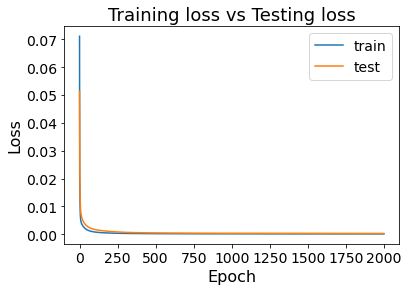

In [33]:
lr = 0.00001
EPOCHS = 2000
model_cnn.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('saved_model/cnn_shift_s{}_k{}.h5'.format(S, K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [34]:
# model_cnn.save('saved_model/cnn_shift_s{}_k{}.h5'.format(S, K))

In [35]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_s{}_k{}.h5'.format(S, K))

In [36]:
# model_load.predict(test_input).shape

### Performance

In [37]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [38]:
# inv_y

In [39]:
# inv_yhat

In [41]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0617
RMSE = 0.0841
